# Importing Data

In [1]:
# Make the necessary imports
import datetime
import pandas as pd
import numpy as np
from statistics import mean

In [2]:
# Read in the csv file exported from Django backend into a dataframe
data = pd.read_csv("new_format_data_cowdy.csv", sep=',', header=0)

In [3]:
# Check the organization of the data
data.head()

id                                              data  \
0  2367349  b'9729,00050000FF03,64,2019-11-14T17:59:30Z,2a*'   
1  2367350  b'272B,000A0000FEFB,64,2019-11-14T17:59:30Z,2a*'   
2  2367351  b'262B,0007000000F8,64,2019-11-14T17:59:30Z,2a*'   
3  2367352  b'2B2B,00050000FF00,64,2019-11-14T17:59:30Z,2a*'   
4  2367353  b'272B,00070000FEFE,64,2019-11-14T17:59:31Z,2a*'   

                   created_at               last_modified  
0  2019-11-15 00:00:00.142968  2019-11-15 00:00:00.142992  
1  2019-11-15 00:00:00.294080  2019-11-15 00:00:00.294104  
2  2019-11-15 00:00:01.070546  2019-11-15 00:00:01.070574  
3  2019-11-15 00:00:01.221148  2019-11-15 00:00:01.221172  
4  2019-11-15 00:00:01.373052  2019-11-15 00:00:01.373076

In [4]:
# Seems all the data is encoded in the data field

In [5]:
data = data['data']

# Parsing and Conversions

In [6]:
def pre_process_data(data):
    x_data = []
    y_data = []
    z_data = []
    time_frame = []
    device_data = []
    battery_level = []
    device_battery = {}
    
    for item in data:
        decoded_item = item[2:-5]
        item_value = decoded_item.split(',')
        #print(item_value)
        
        # Take the device ID information
        device_id = item_value[0]
        
        # The time information is in index 3 of the item_value list
        time_ar = item_value[3]
        times = datetime.datetime.strptime(time_ar, "%Y-%m-%dT%H:%M:%SZ")
        
        # Need to find out why we are adding timedelta of 6 hours. Is it because Dhaka is GMT+6?
        # --> They sent date as UTC, so we've converted it into BST
        time_val = times + datetime.timedelta(hours=6) # why the timedelta? --> using timedelta we can get the time we want and also we can convert the time into GMT+6 but using timedelta we directly converted it into our time format. 
        
        # Take the battery information from index position 2 of the item_value list
        # and convert it from 2-bit to 16-bit integer.
        # --> axis data and battery information was sent as 16-bit integer, now we converted it into decimal
        battery = np.int16(int(item_value[2], 16))
        
        # Take the x, y, z information from index position 1 of the item_value list 
        # and convert it from 2-bit to 16-bit integer
        # x values between string index 0:4 for item_value[1]
        x = (np.int16(int(item_value[1][0:4], 16)))/256 
        # y values between string index 4:8 for item_value[1]
        y = (np.int16(int(item_value[1][4:8], 16)))/256 
        # x values between string index 8:12 for item_value[1]
        z = (np.int16(int(item_value[1][8:], 16)))/256 
        
        # Append the battery, x, y, z, time and device information to the previously initialized lists
        battery_level.append(battery)
        x_data.append(x)
        y_data.append(y)
        z_data.append(z)
        time_frame.append(time_val)
        device_data.append(device_id)
        
    
    # Return all the lists together
    return x_data, y_data, z_data, time_frame, device_data

In [7]:
# Initialize new list variables: x, y, z, time, id  
# using the pre_process() function call
x, y, z, time, id = pre_process_data(data)

# Create new dataframe df using the new list variables
df = pd.DataFrame(list(zip(id, time, x, y, z)), 
               columns =['device_id', 'time', 'x', 'y', 'z']) 

In [8]:
# Check the dataframe that is returned
df.head()

device_id                time         x    y         z
0      9729 2019-11-14 23:59:30  0.019531  0.0 -0.988281
1      272B 2019-11-14 23:59:30  0.039062  0.0 -1.019531
2      262B 2019-11-14 23:59:30  0.027344  0.0  0.968750
3      2B2B 2019-11-14 23:59:30  0.019531  0.0 -1.000000
4      272B 2019-11-14 23:59:31  0.027344  0.0 -1.007812

# Subsetting for one animal

In [9]:
# check the device id data 
df["device_id"].value_counts()

2B2B    12659
9729    12517
262B    12441
272B    12383
Name: device_id, dtype: int64

In [10]:
# seems like data of four cows only

In [11]:
# subset for one cow
animal1 = df[df["device_id"] == "2B2B"]

# now drop the device_id column. we don't need to know it for one animal
animal1 = animal1.drop(columns = ['device_id'])

# now sort by datetime
animal1 = animal1.sort_values(by=['time'])

In [12]:
# check the dataframe
animal1.head()

time         x    y    z
3  2019-11-14 23:59:30  0.019531  0.0 -1.0
6  2019-11-14 23:59:31  0.019531  0.0 -1.0
7  2019-11-14 23:59:32  0.019531  0.0 -1.0
13 2019-11-14 23:59:34  0.019531  0.0 -1.0
17 2019-11-14 23:59:35  0.019531  0.0 -1.0

In [13]:
# reset index
animal1.reset_index(drop=True, inplace=True)

animal1.head()

time         x    y    z
0 2019-11-14 23:59:30  0.019531  0.0 -1.0
1 2019-11-14 23:59:31  0.019531  0.0 -1.0
2 2019-11-14 23:59:32  0.019531  0.0 -1.0
3 2019-11-14 23:59:34  0.019531  0.0 -1.0
4 2019-11-14 23:59:35  0.019531  0.0 -1.0

In [14]:
# Check for duplicates
duplicate_condition = animal1['time'].duplicated()
animal1[duplicate_condition]

time         x         y         z
757   2019-11-15 00:18:12  0.019531  0.000000 -1.000000
1097  2019-11-15 00:26:51  0.019531  0.000000 -1.000000
1452  2019-11-15 00:35:32  0.019531  0.000000 -1.000000
1825  2019-11-15 00:44:09  0.019531  0.000000 -1.000000
2617  2019-11-15 01:01:38  0.019531 -0.007812 -0.988281
4177  2019-11-15 01:36:23  0.007812  0.000000 -1.000000
4858  2019-11-15 01:53:47  0.019531  0.000000 -1.000000
5180  2019-11-15 02:02:32  0.007812 -0.007812 -1.000000
5514  2019-11-15 02:11:13  0.019531  0.000000 -1.000000
6689  2019-11-15 02:45:52  0.019531  0.000000 -1.000000
6984  2019-11-15 02:54:32  0.019531  0.000000 -1.000000
7287  2019-11-15 03:03:21  0.019531  0.000000 -0.988281
7987  2019-11-15 03:20:39  0.019531  0.000000 -1.000000
9112  2019-11-15 03:46:38  0.019531  0.000000 -1.000000
10168 2019-11-15 04:12:37  0.019531  0.000000 -1.000000
11154 2019-11-15 04:38:44  0.019531 -0.007812 -0.988281
12545 2019-11-15 05:13:27  0.019531  0.000000 -1.000000

In [15]:
# check one duplicate
animal1[animal1['time']=="2019-11-15 00:18:12"]

time         x    y    z
756 2019-11-15 00:18:12  0.019531  0.0 -1.0
757 2019-11-15 00:18:12  0.019531  0.0 -1.0

In [16]:
# remove duplicates
animal1 = animal1.drop_duplicates(subset=["time"], keep="first")

In [17]:
# Check for duplicates again
duplicate_condition = animal1['time'].duplicated()
animal1[duplicate_condition]

Empty DataFrame
Columns: [time, x, y, z]
Index: []

In [18]:
# all duplicates have been removed

In [29]:
# check dataframe
animal1.head()

time      x_1s  y_1s  z_1s      x_2s  y_2s  z_2s      x_5s  \
4 2019-11-14 23:59:35  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
5 2019-11-14 23:59:37  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
6 2019-11-14 23:59:38  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
7 2019-11-14 23:59:39  0.027344   0.0  -1.0  0.023438   0.0  -1.0  0.021094   
8 2019-11-14 23:59:40  0.019531   0.0  -1.0  0.023438   0.0  -1.0  0.021094   

   y_5s  z_5s  
4   0.0  -1.0  
5   0.0  -1.0  
6   0.0  -1.0  
7   0.0  -1.0  
8   0.0  -1.0

# Noise Removal by Smoothing

In [19]:
# check length of dataset before smoothening
len(animal1)

12642

In [20]:
# Make rolling average of 1 second
animal1['x_1s'] = animal1['x'].rolling(window=1).mean()
animal1['y_1s'] = animal1['y'].rolling(window=1).mean()
animal1['z_1s'] = animal1['z'].rolling(window=1).mean()

In [21]:
# Make rolling average of 2 seconds
animal1['x_2s'] = animal1['x'].rolling(window=2).mean()
animal1['y_2s'] = animal1['y'].rolling(window=2).mean()
animal1['z_2s'] = animal1['z'].rolling(window=2).mean()

In [22]:
# Make rolling average of 5 seconds
animal1['x_5s'] = animal1['x'].rolling(window=5).mean()
animal1['y_5s'] = animal1['y'].rolling(window=5).mean()
animal1['z_5s'] = animal1['z'].rolling(window=5).mean()


In [23]:
# drop rows with null values for the smoothened data
animal1 = animal1.dropna(axis=0)

# drop columns x, y and z
animal1 = animal1.drop(columns = ['x', 'y', 'z'])

In [24]:
# check dataset length after smoothening
len(animal1)

12638

In [25]:
# seems like the null values have been correctly removed from the dataframe

In [26]:
# check dataframe length
animal1.head()

time      x_1s  y_1s  z_1s      x_2s  y_2s  z_2s      x_5s  \
4 2019-11-14 23:59:35  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
5 2019-11-14 23:59:37  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
6 2019-11-14 23:59:38  0.019531   0.0  -1.0  0.019531   0.0  -1.0  0.019531   
7 2019-11-14 23:59:39  0.027344   0.0  -1.0  0.023438   0.0  -1.0  0.021094   
8 2019-11-14 23:59:40  0.019531   0.0  -1.0  0.023438   0.0  -1.0  0.021094   

   y_5s  z_5s  
4   0.0  -1.0  
5   0.0  -1.0  
6   0.0  -1.0  
7   0.0  -1.0  
8   0.0  -1.0

In [27]:
# Create separate dataframes for each sliding window type
animal1_1s = animal1.drop(columns = ['x_2s', 'y_2s', 'z_2s', 'x_5s', 'y_5s', 'z_5s'])
animal1_2s = animal1.drop(columns = ['x_1s', 'y_1s', 'z_1s', 'x_5s', 'y_5s', 'z_5s'])
animal1_5s = animal1.drop(columns = ['x_1s', 'y_1s', 'z_1s', 'x_2s', 'y_2s', 'z_2s'])

In [28]:
# Now export the data to csv for each rolling window
animal1_1s.to_csv('Parsed_Subset_Data_1s.csv')
animal1_2s.to_csv('Parsed_Subset_Data_2s.csv')
animal1_5s.to_csv('Parsed_Subset_Data_5s.csv')

# Calculating 'x_diff', 'y_diff', 'z_diff' and the 'sum_diff'

In [23]:
# Read in the csv file for any preferred rolling window
cow = pd.read_csv("Parsed_Subset_Data_1s.csv", sep=',', header=0)

# need to drop the index column which becomes written to the csv by default
cow = cow.drop(columns = ['Unnamed: 0'])

# check the dataframe
cow.head()

time      x_1s  y_1s  z_1s
0  2019-11-14 23:59:35  0.019531   0.0  -1.0
1  2019-11-14 23:59:37  0.019531   0.0  -1.0
2  2019-11-14 23:59:38  0.019531   0.0  -1.0
3  2019-11-14 23:59:39  0.027344   0.0  -1.0
4  2019-11-14 23:59:40  0.019531   0.0  -1.0

In [24]:
# looks alright

In [25]:
# now copy the rolling x, y, z columns to newly named x_diff, y_diff, z_diff columns
cow['x_diff'] = cow.iloc[:, 1]
cow['y_diff'] = cow.iloc[:, 2]
cow['z_diff'] = cow.iloc[:, 3]

In [26]:
# check the dataframe
cow.head()

time      x_1s  y_1s  z_1s    x_diff  y_diff  z_diff
0  2019-11-14 23:59:35  0.019531   0.0  -1.0  0.019531     0.0    -1.0
1  2019-11-14 23:59:37  0.019531   0.0  -1.0  0.019531     0.0    -1.0
2  2019-11-14 23:59:38  0.019531   0.0  -1.0  0.019531     0.0    -1.0
3  2019-11-14 23:59:39  0.027344   0.0  -1.0  0.027344     0.0    -1.0
4  2019-11-14 23:59:40  0.019531   0.0  -1.0  0.019531     0.0    -1.0

In [27]:
# Drop the rolling x, y, z columns
# run these in consecutive order
cow.drop(cow.columns[1], axis=1, inplace=True) # e.g., x_1s will be dropped
cow.drop(cow.columns[1], axis=1, inplace=True) # e.g., y_1s will be dropped
cow.drop(cow.columns[1], axis=1, inplace=True) # e.g., z_1s will be dropped

# inplace=True is used to make the changes in the dataframe itself 
# without doing the column dropping on a copy of the data frame.

In [28]:
# check the dataframe
cow.head()

time    x_diff  y_diff  z_diff
0  2019-11-14 23:59:35  0.019531     0.0    -1.0
1  2019-11-14 23:59:37  0.019531     0.0    -1.0
2  2019-11-14 23:59:38  0.019531     0.0    -1.0
3  2019-11-14 23:59:39  0.027344     0.0    -1.0
4  2019-11-14 23:59:40  0.019531     0.0    -1.0

In [29]:
# turn time to index
cow = cow.set_index('time')

# check the dataframe
cow.head()

x_diff  y_diff  z_diff
time                                         
2019-11-14 23:59:35  0.019531     0.0    -1.0
2019-11-14 23:59:37  0.019531     0.0    -1.0
2019-11-14 23:59:38  0.019531     0.0    -1.0
2019-11-14 23:59:39  0.027344     0.0    -1.0
2019-11-14 23:59:40  0.019531     0.0    -1.0

In [30]:
# now calculate the differences between consecutive rows
cow = cow.diff(axis=0, periods=1)


# check dataframe
cow.head()

x_diff  y_diff  z_diff
time                                         
2019-11-14 23:59:35       NaN     NaN     NaN
2019-11-14 23:59:37  0.000000     0.0     0.0
2019-11-14 23:59:38  0.000000     0.0     0.0
2019-11-14 23:59:39  0.007812     0.0     0.0
2019-11-14 23:59:40 -0.007812     0.0     0.0

In [31]:
# now drop rows with na values
cow = cow.dropna()

In [32]:
# check the dataframe again. sorry, minor ocd problem.
cow.head()

x_diff  y_diff  z_diff
time                                         
2019-11-14 23:59:37  0.000000     0.0     0.0
2019-11-14 23:59:38  0.000000     0.0     0.0
2019-11-14 23:59:39  0.007812     0.0     0.0
2019-11-14 23:59:40 -0.007812     0.0     0.0
2019-11-14 23:59:44  0.000000     0.0     0.0

In [33]:
# now calculate the sum_diff
cow['sum_diff'] = abs(cow['x_diff']) + abs(cow['y_diff']) + abs(cow['z_diff'])

In [34]:
# check dataframe again
cow.head()

x_diff  y_diff  z_diff  sum_diff
time                                                   
2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000
2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000
2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812
2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812
2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000

In [35]:
# now export the preprocessed final data to csv
cow.to_csv('Preprocessed_Final.csv')

# Plotting the x_diff, y_diff, z_diff and sum_diff against time

In [36]:
# import plotting libraries and set inline plot
import matplotlib.pyplot as plt 
%matplotlib inline

import datetime

import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(11, 4)})

In [37]:
# import preprocessed final data from csv
new_df = pd.read_csv("Preprocessed_Final.csv", sep=',', header=0)

# if you need to drop the numeric index column which becomes written to the csv by default
# new_df = new_df.drop(columns = ['Unnamed: 0']) 
# not needed if the date was the index

# check the dataframe
new_df.head()

time    x_diff  y_diff  z_diff  sum_diff
0  2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000
1  2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000
2  2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812
3  2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812
4  2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000

In [38]:
# set time as index of dataframe
new_df = new_df.set_index('time')

In [39]:
#convert index from object to datetime
new_df.index = pd.to_datetime(new_df.index)

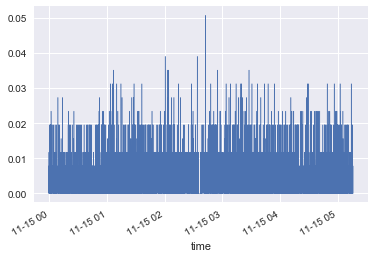

In [40]:
#Let’s create a line plot of the full time series of the animal's accelerometer data, 
#using the DataFrame’s plot() method.

new_df['sum_diff'].plot(linewidth=0.5);

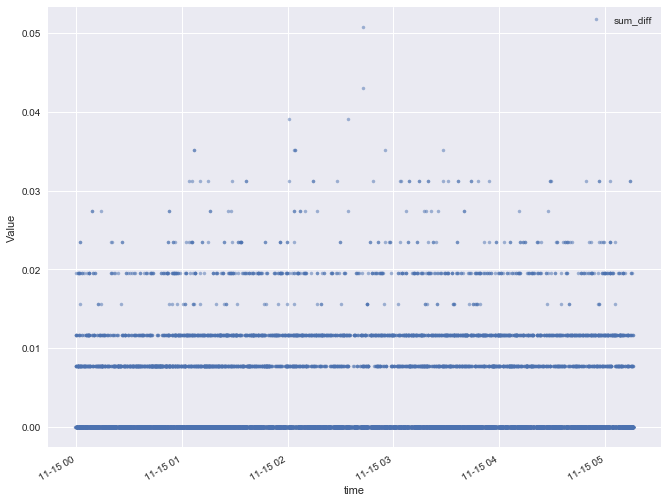

In [41]:
#Let’s plot the data as dots instead, and also look at the temperature time series.
cols_plot = ['sum_diff']

axes = new_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Value')

# K-means

In [42]:
import numpy as np
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [43]:
# import preprocessed final data from csv
km_df = pd.read_csv("Preprocessed_Final.csv", sep=',', header=0)

# drop the time column 
km_df = km_df.drop(columns = ['time']) 


# check the dataframe
km_df.head()

x_diff  y_diff  z_diff  sum_diff
0  0.000000     0.0     0.0  0.000000
1  0.000000     0.0     0.0  0.000000
2  0.007812     0.0     0.0  0.007812
3 -0.007812     0.0     0.0  0.007812
4  0.000000     0.0     0.0  0.000000

In [44]:
# separate the data from the dataframe and convert to np array
X = km_df.values
X = np.nan_to_num(X)

# scale the data
# try two different heuristics: the minmax scaler and the standard scaler 
# and see which works better
# my hunch is the standard scaler should work better since the variables may have covariance
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 0.        ,  0.        ,  0.        , -0.61526164],
       [ 0.        ,  0.        ,  0.        , -0.61526164],
       [ 2.85219298,  0.        ,  0.        ,  0.68492554],
       ...,
       [ 0.        ,  0.        ,  0.        , -0.61526164],
       [ 0.        ,  0.        ,  0.        , -0.61526164],
       [ 0.        ,  0.        ,  0.        , -0.61526164]])

In [45]:
# Check the shape of the np array X
X.shape

(12654, 4)

In [46]:
# Seeems that the array shape turned out alright as intended: n rows x 4 columns. Awesome!

In [47]:
# check dataset length
len(X)

12654

In [48]:
# Initialize the number of clusters. My personal recommendation is 2.
clusterNum = 2

In [49]:
# These are the parameters you can choose for initializing the Kmeans class


# init : {‘k-means++’, ‘random’ or an ndarray}
# Method for initialization, defaults to ‘k-means++’:

# ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
# See section Notes in k_init for more details.

# ‘random’: choose k observations (rows) at random from data for the initial centroids.

# If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

# n_init : int, default: 10
# Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.

# max_iter : int, default: 300

In [50]:
# initialize the kmeans model. 
# for the time being, just tune the init, n_clusters and n_init parameters
# we'll find out more about the optimal number of clusters from the elbow method later
k_means = KMeans(init = "random", n_clusters = clusterNum, n_init = 20)

In [51]:
# fit the model with the data
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=2, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
# separate the labels and check
labels = k_means.labels_
print(labels)

[1 1 0 ... 1 1 1]


In [53]:
# add the labels into a new column to the original dataframe
# we need a labelled dataset to train the svm
km_df["Clus_km"] = labels

# check
km_df.head()

x_diff  y_diff  z_diff  sum_diff  Clus_km
0  0.000000     0.0     0.0  0.000000        1
1  0.000000     0.0     0.0  0.000000        1
2  0.007812     0.0     0.0  0.007812        0
3 -0.007812     0.0     0.0  0.007812        0
4  0.000000     0.0     0.0  0.000000        1

In [54]:
# check whether the clustering makes any nominal sense
km_df.groupby('Clus_km').mean()

x_diff  y_diff  z_diff  sum_diff
Clus_km                                  
0           0.0     0.0     0.0  0.011413
1           0.0     0.0     0.0  0.000000

In [55]:
# seems like the mean sum_diff doesn't vary much for two of the three clusters
# it suggests that there may be optimally two clusters only
# need to check further using the elbow method

In [56]:
# find out the value counts
km_df['Clus_km'].value_counts()

1    8555
0    4099
Name: Clus_km, dtype: int64

In [57]:
# export labeled cluster data
km_df.to_csv('labeled_cluster_output.csv')

# Visualize the kmeans clusters

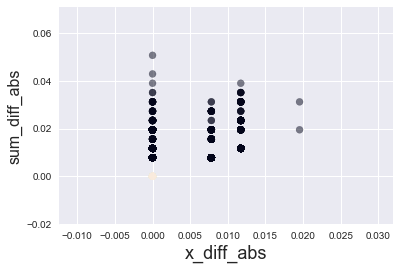

In [58]:
# visualize z_diff against sum_diff in 2d

# create scatter plot using matplotlib plt method

# plot absolute values
plt.scatter(abs(X[:, 0]), abs(X[:, 3]), c=labels.astype(np.float), alpha=0.5)
plt.xlabel('x_diff_abs', fontsize=18)
plt.ylabel('sum_diff_abs', fontsize=16)

# plot real values
# plt.scatter(X[:, 0], X[:, 3], c=labels.astype(np.float), alpha=0.5)
# plt.xlabel('x_diff', fontsize=18)
# plt.ylabel('sum_diff', fontsize=16)

plt.show()

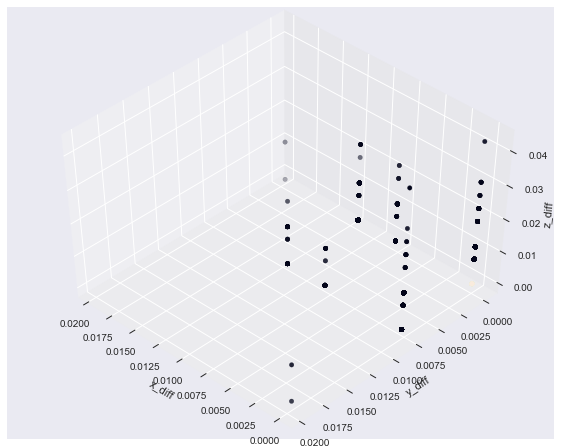

In [59]:
# visualize the clusters in 3d space

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('x_diff')
ax.set_ylabel('y_diff')
ax.set_zlabel('z_diff')

# plot absolute values
ax.scatter(abs(X[:, 0]), abs(X[:, 1]), abs(X[:, 2]), c= labels.astype(np.float))

# plot real values
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c= labels.astype(np.float))

# Apply k-means elbow method

In [60]:
# determine the optimal number of clusters using elbow method

In [61]:
# make necessary imports
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(X))

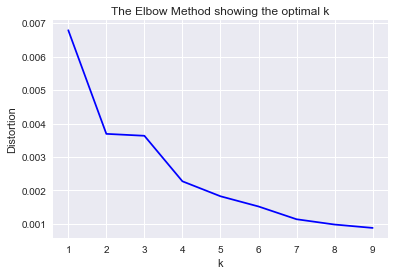

In [63]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [64]:
# Check if there is a big drop in distortion if we switch from 2 to 3 clusters. 
# If not, my recommendation is that we stick to 2 clusters.

# SVC Hyperparameter Tuning using GridSearchCV

The main idea behind it is to create a grid of hyper-parameters and just try all of their combinations.

GridSearchCV takes a dictionary that describes the parameters that could be tried on a model to train it. The grid of parameters is defined as a dictionary, where the keys are the parameters and the values are the settings to be tested.

In [65]:
# Import necessary libraries and get the Data
import pandas as pd 
import numpy as np 
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.svm import SVC 
  

In [66]:
df = pd.read_csv("labeled_cluster_output.csv")

# drop the unwanted index column which was written to the csv by default
df = df.drop(columns = ['Unnamed: 0'])

df.head()

x_diff  y_diff  z_diff  sum_diff  Clus_km
0  0.000000     0.0     0.0  0.000000        1
1  0.000000     0.0     0.0  0.000000        1
2  0.007812     0.0     0.0  0.007812        0
3 -0.007812     0.0     0.0  0.007812        0
4  0.000000     0.0     0.0  0.000000        1

Now we will extract all features into the new dataframe and our target features into separate dataframe.

In [67]:
df_feat = df.drop(columns = ['Clus_km'])
  
# Clus_km column is our target 
df_target = df['Clus_km'] 
  
print("Feature Variables: ") 
print(df_feat.info()) 

Feature Variables: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 4 columns):
x_diff      12654 non-null float64
y_diff      12654 non-null float64
z_diff      12654 non-null float64
sum_diff    12654 non-null float64
dtypes: float64(4)
memory usage: 395.5 KB
None


In [68]:
# check the dataframe
df_feat.head()

x_diff  y_diff  z_diff  sum_diff
0  0.000000     0.0     0.0  0.000000
1  0.000000     0.0     0.0  0.000000
2  0.007812     0.0     0.0  0.007812
3 -0.007812     0.0     0.0  0.007812
4  0.000000     0.0     0.0  0.000000

Now we will split our data into train and test set with 70 : 30 ratio

In [69]:
from sklearn.model_selection import train_test_split 
  
X_train, X_test, y_train, y_test = train_test_split( 
                        df_feat, np.ravel(df_target), 
                test_size = 0.30, random_state = 101) 

#### Train the Support Vector Classifier without Hyper-parameter Tuning
First, we will train our model by calling standard SVC() function without doing Hyper-parameter Tuning and see its classification and confusion matrix.

In [70]:
# train the model on train set 
model = SVC() 
model.fit(X_train, y_train) 
  
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1239
          1       0.67      1.00      0.81      2558

avg / total       0.45      0.67      0.54      3797



C:\Users\Tanzim\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Notice that recall and precision for class 0 are always 0. It means that classifier is always classifying everything into a single class i.e class 1! This means our model needs to have its parameters tuned.

#### Use GridsearchCV
One of the great things about GridSearchCV is that it is a meta-estimator. It takes an estimator like SVC, and creates a new estimator, that behaves exactly the same – in this case, like a classifier. You should add refit=True and choose verbose to whatever number you want, higher the number, the more verbose (verbose just means the text output describing the process).

In [72]:
from sklearn.model_selection import GridSearchCV, cross_val_score
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid']}  
  
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6769387064002709, total=   3.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6771680216802168, total=   1.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, score=0.6771680216802168, total=   1.3s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV]  C=0.1, gamma=1, kernel=sigmoid, score=0.6769387064002709, total=   3.5s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV]  C=0.1, gamma=1, kernel=sigmoid, score=0.6771680216802168, total=   1.5s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV]  C=0.1, gamma=1, kernel=sigmoid, score=0.6771680216802168, total=   2.6s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6769387064002709, total=   1.7s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6771680216802168, total=   1.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV]  C=0.1, gamma=0.1, kernel=rbf, score=0.6771680216802168, total=   4.1s
[CV] C=0.1, gamma=0.1, kernel=sigmoid 

[CV]  C=1, gamma=0.0001, kernel=sigmoid, score=0.6771680216802168, total=   1.1s
[CV] C=1, gamma=0.0001, kernel=sigmoid ...............................
[CV]  C=1, gamma=0.0001, kernel=sigmoid, score=0.6771680216802168, total=   3.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ............. C=10, gamma=1, kernel=rbf, score=1.0, total=   1.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ............. C=10, gamma=1, kernel=rbf, score=1.0, total=   1.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ............. C=10, gamma=1, kernel=rbf, score=1.0, total=   1.5s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] ......... C=10, gamma=1, kernel=sigmoid, score=1.0, total=   3.1s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] ......... C=10, gamma=1, kernel=sigmoid, score=1.0, total=   1.4s
[CV] C=10, gamma=1, kernel=sigmoid ......................

[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.6769387064002709, total=   2.7s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.6771680216802168, total=   2.5s
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV]  C=100, gamma=0.0001, kernel=rbf, score=0.6771680216802168, total=   1.3s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=100, gamma=0.0001, kernel=sigmoid, score=0.6769387064002709, total=   2.3s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=100, gamma=0.0001, kernel=sigmoid, score=0.6771680216802168, total=   1.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=100, gamma=0.0001, kernel=sigmoid, score=0.6771680216802168, total=   1.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ........... C=1000, gamma=1, kernel=rbf, score=1.0, total=   0.0s
[CV] C=1000, gamm

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  6.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

What fit does is a bit more involved then usual. First, it runs the same loop with cross-validation, to find the best parameter combination. Once it has the best combination, it runs fit again on all data passed to fit (without cross-validation), to built a single new model using the best parameter setting.

You can inspect the best parameters found by GridSearchCV in the best_params_ attribute, and the best estimator in the best_estimator_ attribute:

In [73]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Then you can re-run predictions and see classification report on this grid object just like you would with a normal model.

In [74]:
grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1239
          1       1.00      1.00      1.00      2558

avg / total       1.00      1.00      1.00      3797



# Final SVC Model

In [87]:
# importing the libraries
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import os

In [88]:
svm_df = pd.read_csv("labeled_cluster_output.csv")

# drop the unwanted index column which was written to the csv by default
svm_df = svm_df.drop(columns = ['Unnamed: 0'])

svm_df.head()

x_diff  y_diff  z_diff  sum_diff  Clus_km
0  0.000000     0.0     0.0  0.000000        1
1  0.000000     0.0     0.0  0.000000        1
2  0.007812     0.0     0.0  0.007812        0
3 -0.007812     0.0     0.0  0.007812        0
4  0.000000     0.0     0.0  0.000000        1

To divide the data into attributes and labels, execute the following code:

In [89]:
X = svm_df.drop(columns=['Clus_km'])
y = svm_df['Clus_km']

In [90]:
# divide data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101)

In [91]:
# import SVC and initialize the classifier
from sklearn.svm import SVC
svclassifier = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
# fit the classifier into the data
model = svclassifier.fit(X_train, y_train)

In [93]:
# now predict on the test set using the predict method
y_pred = model.predict(X_test)

In [94]:
# evaluate the model now by examining the confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1239    0]
 [   0 2558]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1239
          1       1.00      1.00      1.00      2558

avg / total       1.00      1.00      1.00      3797



In [95]:
# Prediction performance on test set is not as good as on train set
model.score(X_test, y_test)    

1.0

By default, the GridSearchCV uses a 3-fold cross-validation. However, if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold. The default will change to a 5-fold cross-validation in version 0.22.

In [100]:
# import cross_validation_score
from sklearn.model_selection import cross_val_score


# Nested cross validation score
cross_val_score(model, X, y) 

array([1., 1., 1.])

In [104]:
# Already defined in a line above, so commenting it out
# svclassifier = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)

In [106]:
# The following line estimates the accuracy of the support vector machine 
# on the dataset by splitting the data, fitting a model 
# and computing the score 5 consecutive times (with different splits each time):
scores = cross_val_score(svclassifier, X, y, cv=5)
scores

array([1., 1., 1., 1., 1.])

In [107]:
# The mean score and the 95% confidence interval of the score estimate are hence given by:

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 1.00 (+/- 0.00)


In [108]:
# I think I could have overfitted the SVC model

In [152]:
# save the svm model
path = os.getcwd()
joblib.dump(model, path + "/svm_for_cow.pkl")

['C:\\Users\\Tanzim\\Documents\\ClubGIS\\Misfit tech\\Cowdy\\Predicting-Estrus-in-Cattle-from-Accelerometer-Data/svm_for_cow.pkl']

# Predict using the SVC model

In [198]:
# Necessary imports
import datetime
import pandas as pd
from sklearn.externals import joblib

In [199]:
# Read in the csv file for any preferred rolling window
cow = pd.read_csv("Parsed_Subset_Data_1s.csv", sep=',', header=0)

# need to drop the index column which becomes written to the csv by default
cow = cow.drop(columns = ['Unnamed: 0'])

In [200]:
# rename columns
cow.rename(columns={ cow.columns[1]: "x_diff" }, inplace = True)
cow.rename(columns={ cow.columns[2]: "y_diff" }, inplace = True)
cow.rename(columns={ cow.columns[3]: "z_diff" }, inplace = True)

# turn time to index
cow = cow.set_index('time')

# now calculate the differences between consecutive rows
cow = cow.diff(axis=0, periods=1)

# now calculate the sum_diff
cow['sum_diff'] = abs(cow['x_diff']) + abs(cow['y_diff']) + abs(cow['z_diff'])

# now drop rows with na values
cow = cow.dropna()

In [201]:
# check 
cow.head()

x_diff  y_diff  z_diff  sum_diff
time                                                   
2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000
2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000
2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812
2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812
2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000

In [202]:
# Load model from file
classifier = joblib.load("svm_for_cow.pkl")

In [203]:
# now predict on the test set using the predict method
y_pred = classifier.predict(cow)

In [204]:
labels = y_pred

cow['labels'] = labels

In [205]:
# check 
cow.head()

x_diff  y_diff  z_diff  sum_diff  labels
time                                                           
2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000       1
2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000       1
2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812       0
2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812       0
2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000       1

In [206]:
# output csv
cow.to_csv('cow_activity_labeled.csv')

In [183]:
# find out the value counts
cow['labels'].value_counts()

1    8555
0    4099
Name: labels, dtype: int64

In [190]:
cow['counts'] = cow.groupby('labels')['labels'].transform('count')

In [191]:
cow.head()

x_diff  y_diff  z_diff  sum_diff  labels  counts
time                                                                   
2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000       1    8555
2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000       1    8555
2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812       0    4099
2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812       0    4099
2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000       1    8555

# Activity Index

The weight of
each category is estimated in the experiments and takes
value from {0, 1}.

In [328]:
import pandas as pd
from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta

In [329]:
cow = pd.read_csv('cow_activity_labeled.csv')

In [330]:
cow.head()

time    x_diff  y_diff  z_diff  sum_diff  labels
0  2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000       1
1  2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000       1
2  2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812       0
3  2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812       0
4  2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000       1

In [331]:
cow['weight'] = None

In [332]:
cow['weight'].value_counts()

Series([], Name: weight, dtype: int64)

In [333]:
for i in range(len(cow)):
    if (cow.iloc[i, 5]==1):
        cow.iloc[i, 6]=0
    else:
        cow.iloc[i, 6]=1

In [334]:
cow.head()

time    x_diff  y_diff  z_diff  sum_diff  labels  weight
0  2019-11-14 23:59:37  0.000000     0.0     0.0  0.000000       1       0
1  2019-11-14 23:59:38  0.000000     0.0     0.0  0.000000       1       0
2  2019-11-14 23:59:39  0.007812     0.0     0.0  0.007812       0       1
3  2019-11-14 23:59:40 -0.007812     0.0     0.0  0.007812       0       1
4  2019-11-14 23:59:44  0.000000     0.0     0.0  0.000000       1       0

In [335]:
#convert time column from str to datetime type
cow['time'] = pd.to_datetime(cow['time'])

cow = cow.sort_values(by=['time'])

In [408]:
# find duplicate time values
cow[cow['time'].duplicated()]
# dummy

time    x_diff    y_diff    z_diff  sum_diff  labels  \
751   2019-11-15 00:18:12  0.000000  0.000000  0.000000  0.000000       1   
1092  2019-11-15 00:26:51  0.000000  0.000000  0.000000  0.000000       1   
1447  2019-11-15 00:35:32 -0.007812  0.000000  0.000000  0.007812       0   
1820  2019-11-15 00:44:09  0.000000  0.000000  0.000000  0.000000       1   
2612  2019-11-15 01:01:38  0.000000  0.000000  0.011719  0.011719       0   
4172  2019-11-15 01:36:23 -0.011719  0.000000  0.000000  0.011719       0   
4853  2019-11-15 01:53:47  0.000000  0.000000  0.000000  0.000000       1   
5174  2019-11-15 02:02:32  0.000000 -0.007812  0.000000  0.007812       0   
5509  2019-11-15 02:11:13  0.000000  0.000000  0.000000  0.000000       1   
6683  2019-11-15 02:45:52  0.000000  0.000000  0.000000  0.000000       1   
6979  2019-11-15 02:54:32  0.000000  0.000000  0.000000  0.000000       1   
7282  2019-11-15 03:03:21  0.000000  0.000000  0.011719  0.011719       0   
7981  2019-11-15 03:20:39  0.000000  0.000000  0.000000  0.000000       1   
9106  2019-11-15 03:46:38  0.000000  0.000000  0.000000  0.000000       1   
10163 2019-11-15 04:12:37  0.000000  0.000000  0.000000  0.000000       1   
11149 2019-11-15 04:38:44  0.000000 -0.007812  0.011719  0.019531       0   
12540 2019-11-15 05:13:27  0.000000  0.000000  0.000000  0.000000       1   

       weight  
751         0  
1092        0  
1447        1  
1820        0  
2612        1  
4172        1  
4853        0  
5174        1  
5509        0  
6683        0  
6979        0  
7282        1  
7981        0  
9106        0  
10163       0  
11149       1  
12540       0

In [412]:
# check further
cow[cow['time'] == "2019-11-15 00:35:32"]

time    x_diff  y_diff  z_diff  sum_diff  labels  weight
1446 2019-11-15 00:35:32  0.007812     0.0     0.0  0.007812       0       1
1447 2019-11-15 00:35:32 -0.007812     0.0     0.0  0.007812       0       1

In [336]:
# find the initial time value
starting_time = cow.iloc[0, 0]

# Check the data type for time
print(type(initial_time))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [471]:
# initialize the lists that are to be appended in the loop
time = []

activity_level = []

# create empty dataframe
#df = pd.DataFrame(columns=['time', 'weight', 's'])


# template
# Create new dataframe df using the new list variables
# df = pd.DataFrame(list(zip(id, time, x, y, z)), 
#                columns =['device_id', 'time', 'x', 'y', 'z'])

In [472]:
len(cow)

12654

In [473]:
# create one hour time slices
end_time = starting_time

while (end_time <= cow.iloc[len(cow)-1, 0]):

    new_time = end_time
    end_time = new_time + timedelta(hours=1) # one hour slice
    # create date filter mask
    # greater than the start date and smaller than the end date
    mask = (cow['time'] > new_time) & (cow['time'] <= end_time)
    placeholder = cow[mask]
    #print('value counts\n', placeholder['labels'].value_counts())
    summary = pd.DataFrame(placeholder['labels'].value_counts())
    summary['cluster'] = summary.index
    # rename columns
    summary.rename(columns={ summary.columns[0]: "count" }, inplace = True)

    # add weights column
    summary['weight'] = None
    for i in range(len(summary)):
        if (summary.iloc[i, 1]==1):
            summary.iloc[i, 2]=0
        else:
            summary.iloc[i, 2]=1

    #print(type(summary))
    #print(summary)

    hourly_activity_level = []

    for i in range(len(summary)):
        activity_level.append(summary.iloc[i, 0]*summary.iloc[i, 2])

    hourly_activity_level = sum(hourly_activity_level)

    time.append(new_time)
    activity_level.append(hourly_activity_level)
    
        

In [474]:
activity_df = pd.DataFrame(list(zip(time, activity_level)), 
               columns =['time', 'activity_level'])

In [475]:
activity_df['time'] = pd.to_datetime(activity_df['time'])

In [476]:
activity_df

time  activity_level
0 2019-11-14 23:59:37               0
1 2019-11-15 00:59:37             800
2 2019-11-15 01:59:37               0
3 2019-11-15 02:59:37               0
4 2019-11-15 03:59:37             870
5 2019-11-15 04:59:37               0

In [477]:
len(activity_df)

6

In [478]:
activity_df['activity_level_1'] = None
activity_df['activity_level_24'] = None
activity_df['activity_level_48'] = None
activity_df['activity_level_72'] = None

In [479]:
activity_df.head()

time  activity_level activity_level_1 activity_level_24  \
0 2019-11-14 23:59:37               0             None              None   
1 2019-11-15 00:59:37             800             None              None   
2 2019-11-15 01:59:37               0             None              None   
3 2019-11-15 02:59:37               0             None              None   
4 2019-11-15 03:59:37             870             None              None   

  activity_level_48 activity_level_72  
0              None              None  
1              None              None  
2              None              None  
3              None              None  
4              None              None

In [480]:
for i in range(len(activity_df)):

    timevalue_1 = activity_df.iloc[i, 0] - timedelta(hours=1)
    timevalue_24 = activity_df.iloc[i, 0] - timedelta(hours=24)
    timevalue_48 = activity_df.iloc[i, 0] - timedelta(hours=48)
    timevalue_72 = activity_df.iloc[i, 0] - timedelta(hours=72)
    
    try:  
        # some errors arise due to duplicate time values being present in the data
        # trying to resolve the issue of duplicates
        activity_df.iloc[i, 2] = activity_df.loc[activity_df['time']==timevalue_1]['activity_level'].values[0]
        activity_df.iloc[i, 3] = activity_df.loc[activity_df['time']==timevalue_24]['activity_level'].values[0]
        activity_df.iloc[i, 4] = activity_df.loc[activity_df['time']==timevalue_48]['activity_level'].values[0]
        activity_df.iloc[i, 5] = activity_df.loc[activity_df['time']==timevalue_72]['activity_level'].values[0]
    except:
        pass

In [481]:
activity_df

time  activity_level activity_level_1 activity_level_24  \
0 2019-11-14 23:59:37               0             None              None   
1 2019-11-15 00:59:37             800                0              None   
2 2019-11-15 01:59:37               0              800              None   
3 2019-11-15 02:59:37               0                0              None   
4 2019-11-15 03:59:37             870                0              None   
5 2019-11-15 04:59:37               0              870              None   

  activity_level_48 activity_level_72  
0              None              None  
1              None              None  
2              None              None  
3              None              None  
4              None              None  
5              None              None

In [482]:
activity_df['historical_comparison_value'] = None
activity_df['trend'] = None
activity_df['activity_index'] = None

In [483]:
activity_df.head()

time  activity_level activity_level_1 activity_level_24  \
0 2019-11-14 23:59:37               0             None              None   
1 2019-11-15 00:59:37             800                0              None   
2 2019-11-15 01:59:37               0              800              None   
3 2019-11-15 02:59:37               0                0              None   
4 2019-11-15 03:59:37             870                0              None   

  activity_level_48 activity_level_72 historical_comparison_value trend  \
0              None              None                        None  None   
1              None              None                        None  None   
2              None              None                        None  None   
3              None              None                        None  None   
4              None              None                        None  None   

  activity_index  
0           None  
1           None  
2           None  
3           None  
4           None

In [484]:
for i in range(len(activity_df)):
    
    # calculate the historical comparison value
    try:
        placeholder = 3*activity_df.loc[i, 'activity_level']
        placeholder = placeholder - (activity_df.loc[i, 'activity_level_24'] + activity_df.loc[i, 'activity_level_48'] + activity_df.loc[i, 'activity_level_72'])
        historical_comparison_value = placeholder/(activity_df.loc[i, 'activity_level_24'] + activity_df.loc[i, 'activity_level_48'] + activity_df.loc[i, 'activity_level_72'])
    except:
        pass
    
    # calculate the trend
    try:
        trend = (activity_df.loc[i, 'activity_level'] - activity_df.loc[i, 'activity_level_1'])/activity_df.loc[i, 'activity_level_1']
    except:
        pass
    
    # insert the values for historical comparison value and trend into the dataframe
    try:
        activity_df.loc[i, 'historical_comparison_value'] = historical_comparison_value
        activity_df.loc[i, 'trend'] = trend
    except:
        pass
    
    
    # calculate the activity index now
    try:
        activity_df.loc[i, 'activity_index'] = historical_comparison_value + trend
    except:
        pass
    

C:\Users\Tanzim\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in longlong_scalars
  del sys.path[0]
C:\Users\Tanzim\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  del sys.path[0]


In [485]:
activity_df.head()

time  activity_level activity_level_1 activity_level_24  \
0 2019-11-14 23:59:37               0             None              None   
1 2019-11-15 00:59:37             800                0              None   
2 2019-11-15 01:59:37               0              800              None   
3 2019-11-15 02:59:37               0                0              None   
4 2019-11-15 03:59:37             870                0              None   

  activity_level_48 activity_level_72 historical_comparison_value trend  \
0              None              None                        None  None   
1              None              None                        None  None   
2              None              None                        None  None   
3              None              None                        None  None   
4              None              None                        None  None   

  activity_index  
0           None  
1           None  
2           None  
3           None  
4           None

In [486]:
activity_index_df = activity_df.drop(columns=['activity_level', 'activity_level_1',
                                             'activity_level_24', 'activity_level_48',
                                             'activity_level_72', 'historical_comparison_value',
                                             'trend'])

activity_index_df.head()

time activity_index
0 2019-11-14 23:59:37           None
1 2019-11-15 00:59:37           None
2 2019-11-15 01:59:37           None
3 2019-11-15 02:59:37           None
4 2019-11-15 03:59:37           None

In [487]:
activity_index_df.to_csv('activity_index.csv')